Feature types summary:
Numeric (16): ['AREA', 'PERIMETER', 'MAJOR_AXIS', 'MINOR_AXIS', 'ECCENTRICITY', 'EQDIASQ', 'SOLIDITY', 'CONVEX_AREA', 'EXTENT', 'ASPECT_RATIO', 'ROUNDNESS', 'COMPACTNESS', 'SHAPEFACTOR_1', 'SHAPEFACTOR_2', 'SHAPEFACTOR_3', 'SHAPEFACTOR_4']
Categorical (0): []


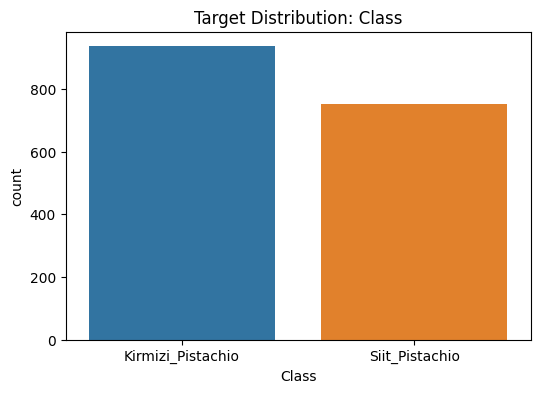

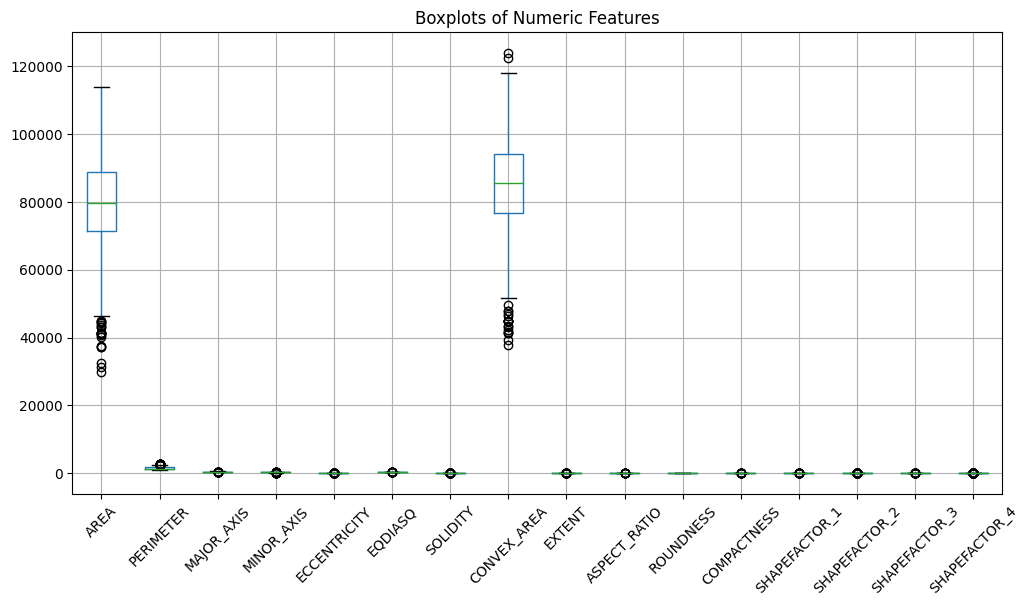

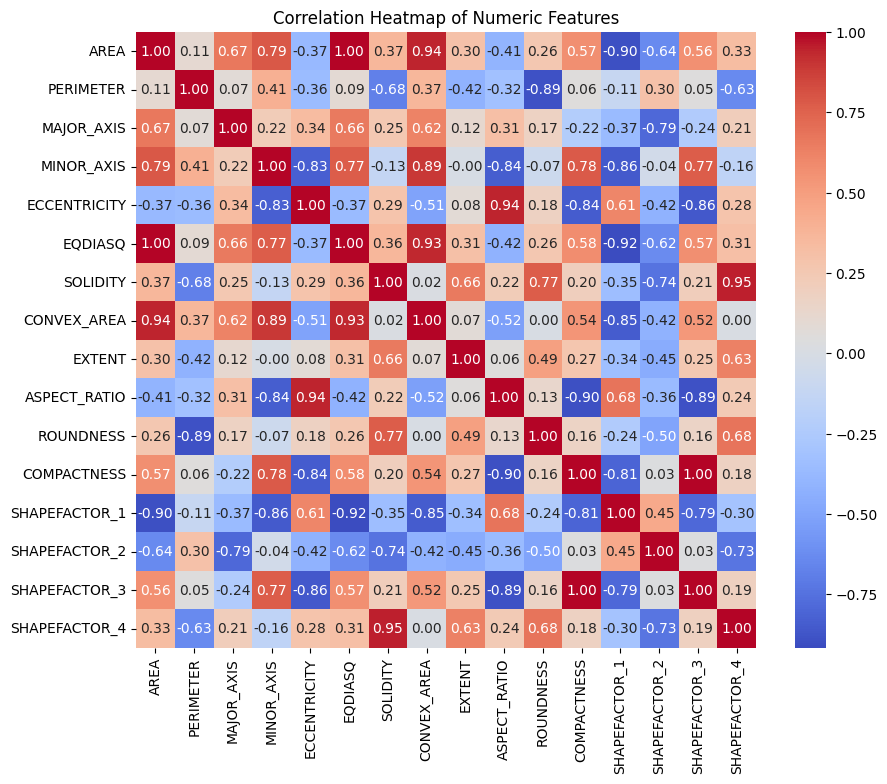

Detected task type: classification
Accuracy: 0.8846
F1 Score: 0.8845
ROC-AUC: 0.9542


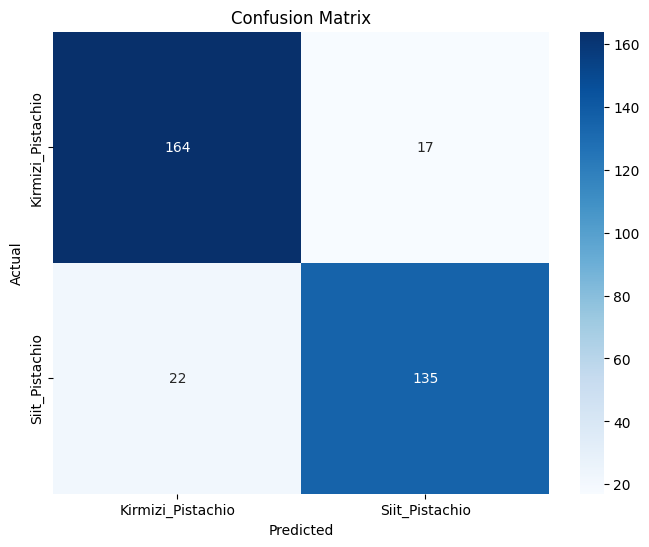

submission.csv created successfully!


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import (accuracy_score, f1_score, roc_auc_score,
                             mean_squared_error, r2_score, confusion_matrix)

# ===================== SETTINGS =====================
REMOVE_OUTLIERS = True  # Remove outliers for regression
VISUALIZE = True        # Generate plots

# ===================== LOAD TRAIN DATA =====================
df = pd.read_csv('/kaggle/input/mse-2-ai-201-b-ai-a/train.csv')
target_col = df.columns[-1]
df = df.dropna(subset=[target_col])
X = df.drop(columns=[target_col])
y = df[target_col]

# ===================== FEATURE TYPES =====================
numeric_cols = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = X.select_dtypes(include='object').columns.tolist()

print("Feature types summary:")
print(f"Numeric ({len(numeric_cols)}): {numeric_cols}")
print(f"Categorical ({len(categorical_cols)}): {categorical_cols}")

# ===================== TARGET VISUALIZATION =====================
if VISUALIZE:
    plt.figure(figsize=(6,4))
    if y.dtype.kind in 'O' or y.dtype.name == 'category':  # categorical
        sns.countplot(x=y)
        plt.title(f"Target Distribution: {target_col}")
    else:
        sns.histplot(y, kde=True)
        plt.title(f"Target Distribution: {target_col}")
    plt.show()

# ===================== BOX PLOT =====================
if VISUALIZE and numeric_cols:
    plt.figure(figsize=(12,6))
    X[numeric_cols].boxplot(rot=45)
    plt.title("Boxplots of Numeric Features")
    plt.show()

# ===================== CORRELATION HEATMAP =====================
if VISUALIZE and numeric_cols:
    plt.figure(figsize=(10,8))
    corr = X[numeric_cols].corr()
    sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm")
    plt.title("Correlation Heatmap of Numeric Features")
    plt.show()

# ===================== CATEGORICAL COUNTS =====================
if VISUALIZE and categorical_cols:
    for col in categorical_cols:
        plt.figure(figsize=(6,4))
        sns.countplot(x=col, data=X, order=X[col].value_counts().index)
        plt.title(f"Counts of {col}")
        plt.xticks(rotation=45)
        plt.show()

# ===================== TASK DETECTION =====================
def detect_task(y):
    if y.dtype.kind in 'biufc' and y.nunique() > 10:
        return 'regression'
    else:
        return 'classification'

task_type = detect_task(y)
print(f"Detected task type: {task_type}")

# ===================== TRAIN-TEST SPLIT =====================
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ===================== OUTLIER REMOVAL =====================
def remove_outliers_iqr(df, numeric_cols):
    df_clean = df.copy()
    for col in numeric_cols:
        Q1 = df_clean[col].quantile(0.25)
        Q3 = df_clean[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        df_clean = df_clean[(df_clean[col] >= lower) & (df_clean[col] <= upper)]
    return df_clean

if REMOVE_OUTLIERS and task_type == 'regression':
    train_combined = X_train.copy()
    train_combined[target_col] = y_train
    train_clean = remove_outliers_iqr(train_combined, numeric_cols)
    X_train = train_clean.drop(columns=[target_col])
    y_train = train_clean[target_col]
    print(f"Training rows before: {train_combined.shape[0]}, after: {train_clean.shape[0]}")

# ===================== TARGET ENCODING =====================
if task_type == 'classification':
    le = LabelEncoder()
    y_train = le.fit_transform(y_train)
    y_test = le.transform(y_test)

# ===================== PREPROCESSOR =====================
def get_preprocessor(numeric_cols, categorical_cols):
    return ColumnTransformer(transformers=[
        ("num", SimpleImputer(strategy='mean'), numeric_cols),
        ("cat_low", Pipeline([
            ("imputer", SimpleImputer(strategy='most_frequent')),
            ("onehot", OneHotEncoder(handle_unknown='ignore', sparse_output=False))
        ]), [col for col in categorical_cols if df[col].nunique() <= 20]),
        ("cat_high", Pipeline([
            ("imputer", SimpleImputer(strategy='most_frequent')),
            ("ordinal", OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
        ]), [col for col in categorical_cols if df[col].nunique() > 20])
    ])

preprocessor = get_preprocessor(numeric_cols, categorical_cols)

# ===================== MODEL =====================
model = RandomForestClassifier(n_estimators=200, max_depth=30, random_state=42) \
        if task_type=='classification' else \
        RandomForestRegressor(n_estimators=200, max_depth=30, random_state=42)

# ===================== PIPELINE =====================
pipeline = Pipeline([('preprocessor', preprocessor), ('model', model)])
pipeline.fit(X_train, y_train)

# ===================== EVALUATION =====================
y_pred = pipeline.predict(X_test)

if task_type == 'classification':
    y_proba = pipeline.predict_proba(X_test)
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print(f"F1 Score: {f1_score(y_test, y_pred, average='weighted'):.4f}")
    if y_proba.shape[1] > 2:
        print(f"ROC-AUC (OVR): {roc_auc_score(y_test, y_proba, multi_class='ovr'):.4f}")
    else:
        print(f"ROC-AUC: {roc_auc_score(y_test, y_proba[:,1]):.4f}")

    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=le.classes_,
                yticklabels=le.classes_)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()
else:
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print(f"Mean Squared Error: {mse:.4f}")
    print(f"R2 Score: {r2:.4f}")


# ===================== LOAD TEST DATA =====================
df_test = pd.read_csv('/kaggle/input/mse-2-ai-201-b-ai-a/test.csv')
test_ids = df_test["id"]
X_test_final = df_test.drop(columns=['id'])

# Add missing columns
for col in X_train.columns:
    if col not in X_test_final.columns:
        X_test_final[col] = np.nan
X_test_final = X_test_final[X_train.columns]

# Transform and predict
X_test_transformed = pipeline.named_steps['preprocessor'].transform(X_test_final)

if task_type == 'classification':
    y_test_pred = pipeline.predict(X_test_final)
    y_test_pred = le.inverse_transform(y_test_pred)  # convert back to original labels
    submission = pd.DataFrame({
        "id": test_ids,
        "Prediction": y_test_pred
    })
else:
    y_test_pred = pipeline.predict(X_test_transformed)
    submission = pd.DataFrame({
        "id": test_ids,
        "Prediction": y_test_pred
    })


#submission.insert(0, 'id', test_ids)
submission.to_csv("submission_universal.csv", index=False, float_format="%.6f")
print("submission.csv created successfully!")